# IMDB Dataset Sentiment Analysis

## Common Utilities

In [1]:
# utilities
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# tensorflow utilities
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tensorflow dataset
!pip install tensorflow_datasets
import tensorflow_datasets as tfds

print(tf.__version__)

     |████████████████████████████████| 3.3 MB 4.7 MB/s 
2.1.0


## Data Pre-processing and Text Cleaning

In [2]:
# utilities for cleaning text
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

# removing stopwords
def remove_stopwords(text):
    stop_words = set(stopwords)
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

# remove punctuation, set all characters to lower case
# text cleaning is an important step of preprocessing as it normalizes the data
def clean_text(text):
    text = re.sub("\'", "", text) 
    text = re.sub("[^a-zA-Z]"," ",text) 
    text = ' '.join(text.split()) 
    text = text.lower()
    _t = ""
    text = remove_stopwords(text)

    return text

In [3]:
# loading dataset from tensorflow datasets
data = tfds.load('imdb_reviews')

# extracting texts and labels
train_data_label = []
train_data_texts = []
for i in data['train']:
  this_label = i['label'].numpy()
  this_text = clean_text(i['text'].numpy().decode('utf-8'))
  train_data_label.append(this_label)
  train_data_texts.append(this_text)

test_data_label = []
test_data_texts = []
for i in data['train']:
  this_label = i['label'].numpy()
  this_text = clean_text(i['text'].numpy().decode('utf-8'))
  test_data_label.append(this_label)
  test_data_texts.append(this_text)

df_train = pd.DataFrame(columns=['text', 'label'])
df_test = pd.DataFrame(columns=['text', 'label'])

df_train['text'] = train_data_texts
df_train['label'] = train_data_label

df_test['text'] = test_data_texts
df_test['label'] = test_data_label

# shape of train and test dataset
print('train shape:', df_train.shape)
print('test shape:', df_test.shape)

df_train.head()
df_train.label.unique()

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9VUBLJ/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9VUBLJ/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9VUBLJ/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
train shape: (25000, 2)
test shape: (25000, 2)


array([0, 1])

In [4]:
# Hyper-parameters for Embedding Layer
vocab_size = 10000
embedding_dim = 16
max_length = 120

# tokenizing and sequencing training texts
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train.text.values)
train_word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df_train.text.values)
train_padded = pad_sequences(sequences, padding='post', truncating='post', maxlen=max_length)

# tokenizing and sequencing validation texts
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df_test.text.values)
test_word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df_test.text.values)
test_padded = pad_sequences(sequences, padding='post', truncating='post', maxlen=max_length)

## Prediction Model Design

In [5]:
# a humble model
# architecture: Embedding Layer -> 1 Sigmoid
model = tf.keras.Sequential(
    [
     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

# compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1921      
Total params: 161,921
Trainable params: 161,921
Non-trainable params: 0
_________________________________________________________________


## Prediction Model Training

In [6]:
# training the model
num_epochs = 10
history = model.fit(train_padded, df_train.label.values, epochs=num_epochs, validation_data=(test_padded, df_test.label.values), verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 - 4s - loss: 0.4830 - accuracy: 0.7650 - val_loss: 0.2551 - val_accuracy: 0.9081
Epoch 2/10
25000/25000 - 3s - loss: 0.2433 - accuracy: 0.9077 - val_loss: 0.1591 - val_accuracy: 0.9542
Epoch 3/10
25000/25000 - 3s - loss: 0.1597 - accuracy: 0.9475 - val_loss: 0.0953 - val_accuracy: 0.9808
Epoch 4/10
25000/25000 - 3s - loss: 0.0933 - accuracy: 0.9781 - val_loss: 0.0527 - val_accuracy: 0.9925
Epoch 5/10
25000/25000 - 3s - loss: 0.0499 - accuracy: 0.9925 - val_loss: 0.0283 - val_accuracy: 0.9976
Epoch 6/10
25000/25000 - 3s - loss: 0.0266 - accuracy: 0.9977 - val_loss: 0.0154 - val_accuracy: 0.9995
Epoch 7/10
25000/25000 - 3s - loss: 0.0143 - accuracy: 0.9993 - val_loss: 0.0084 - val_accuracy: 0.9999
Epoch 8/10
25000/25000 - 3s - loss: 0.0081 - accuracy: 0.9999 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 9/10
25000/25000 - 3s - loss: 0.0047 - accuracy: 0.9999 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 10/10
25

## Plotting Model Training Results

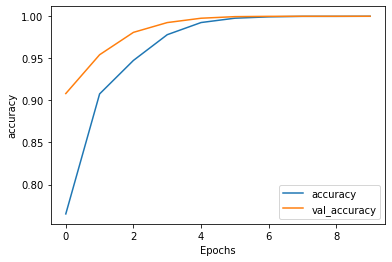

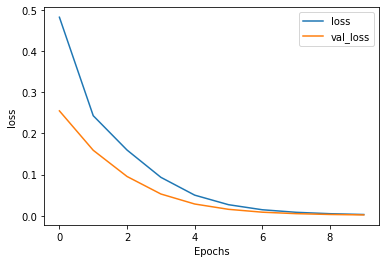

In [7]:
# plotting the training and validation accuracy and loss
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')